In [1]:
import logging
import os
from pathlib import Path

import cartopy.crs as ccrs
import cmaps
import geopandas
import holoviews as hv
import hvplot.pandas
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uxarray
import xarray
from sklearn.neighbors import BallTree as SKBallTree
from util import dBZfunc, dec_ax, z_to_dbz, xtime

try:  # Avoid ValueError when assigning cmap again
    cmap = cmaps.WhiteBlueGreenYellowRed
except ValueError:
    pass

In [2]:
uxarray.__version__

'2025.6.1.dev37+gf4af4983'

In [3]:
idate = pd.to_datetime("20240521T00")
itime = 2
base_path = (
    Path("/glade/campaign/mmm/parc/schwartz/HWT2024/mpas")
    / idate.strftime("%Y%m%d%H")
    / "post/mem_5"
)
grid_path = "/glade/campaign/mmm/parc/schwartz/MPAS/15-3km_mesh/mpas_init/static.nc"
# Paths to Data Variable files
data_paths = [
    d.strftime("diag.%Y-%m-%d_%H.%M.%S.nc")
    for d in pd.date_range(
        start=idate + pd.Timedelta(hours=3),
        end=idate + pd.Timedelta(hours=18),
        freq="3h",
    )
]
data_paths = [base_path / name for name in data_paths]

uxds = uxarray.open_mfdataset(grid_path, data_paths, preprocess=xtime, use_dual=False)
uxds

<xarray.UxDataset> Size: 16GB
Dimensions:                 (valid_time: 6, n_face: 6488066, n_node: 12976128,
                             nSoilLevels: 4, initial_time: 1, mem: 1)
Coordinates:
  * initial_time            (initial_time) datetime64[ns] 8B 2024-05-21
  * mem                     (mem) int64 8B 5
  * valid_time              (valid_time) datetime64[ns] 48B 2024-05-21T03:00:...
Dimensions without coordinates: n_face, n_node, nSoilLevels
Data variables: (12/100)
    xtime                   (valid_time) |S64 384B b'2024-05-21_03:00:00     ...
    olrtoa                  (valid_time, n_face) float32 156MB dask.array<chunksize=(1, 926867), meta=np.ndarray>
    rainc                   (valid_time, n_face) float32 156MB dask.array<chunksize=(1, 926867), meta=np.ndarray>
    rainnc                  (valid_time, n_face) float32 156MB dask.array<chunksize=(1, 926867), meta=np.ndarray>
    refl10cm_max            (valid_time, n_face) float32 156MB dask.array<chunksize=(1, 926867), meta=np.ndarray>
    refl10cm_1km            (valid_time, n_face) float32 156MB dask.array<chunksize=(1, 926867), meta=np.ndarray>
    ...                      ...
    ushr01                  (valid_time, n_face) float32 156MB dask.array<chunksize=(1, 926867), meta=np.ndarray>
    vshr01                  (valid_time, n_face) float32 156MB dask.array<chunksize=(1, 926867), meta=np.ndarray>
    rainc_hrly              (valid_time, n_face) float32 156MB dask.array<chunksize=(1, 926867), meta=np.ndarray>
    rainnc_hrly             (valid_time, n_face) float32 156MB dask.array<chunksize=(1, 926867), meta=np.ndarray>
    total_precip_hrly       (valid_time, n_face) float32 156MB dask.array<chunksize=(1, 926867), meta=np.ndarray>
    forecastHour            (valid_time) float64 48B 3.0 6.0 9.0 12.0 15.0 18.0

In [4]:
# limit to lat lon box

lon_bounds = (-100, -90)
lat_bounds = (37, 43)

extent = [*lon_bounds, *lat_bounds]

projection = ccrs.LambertConformal(central_longitude=-82, standard_parallels=(30, 60))
var = uxds["refl10cm_max"].isel(valid_time=itime).subset.bounding_box(lon_bounds, lat_bounds)
norm = mpl.colors.Normalize(vmin=-10, vmax=55)
var

<xarray.UxDataArray 'refl10cm_max' (n_face: 71038)> Size: 284kB
dask.array<getitem, shape=(71038,), dtype=float32, chunksize=(71038,), chunktype=numpy.ndarray>
Coordinates:
    valid_time  datetime64[ns] 8B 2024-05-21T09:00:00
Dimensions without coordinates: n_face
Attributes:
    units:      dBZ
    long_name:  10 cm maximum radar reflectivity

CPU times: user 41.8 s, sys: 1.83 s, total: 43.6 s
Wall time: 39.5 s


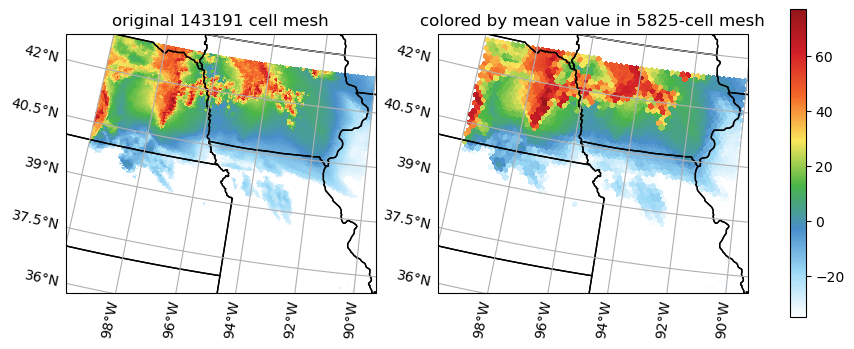

In [5]:
%%time
%matplotlib inline
fig, axes = plt.subplots(
    ncols=2,
    figsize=(11, 4),
    subplot_kw=dict(projection=projection),
)

ax = axes[0]
ax.set_title(f"original {var.uxgrid.node_lon.size} cell mesh")
cc = var.to_polycollection()
cc.set_antialiased(False)  # for speed
cc.set_cmap(cmap)

ax.add_artist(cc)
fig.colorbar(cc, ax=axes)

# Upscale to coarse mesh
coarse_mesh_path = Path(
    "/glade/campaign/mmm/parc/schwartz/MPAS_regional/15km_mesh_regional/mpas_init/regional_15km_mesh_2000km.static.nc"
)

coarse_mesh = uxarray.open_grid(coarse_mesh_path).subset.bounding_box(lon_bounds, lat_bounds)

X = np.c_[coarse_mesh.face_lat, coarse_mesh.face_lon]
# List MPAS indices closest to each coarse mesh cell
idxs = SKBallTree(np.deg2rad(X), metric="haversine").query(
    np.deg2rad(np.c_[var.uxgrid["face_lat"], var.uxgrid["face_lon"]]), return_distance=False
)

data = np.empty(coarse_mesh.face_lon.shape)
axes[1].set_title(f"colored by mean value in {coarse_mesh.node_lon.size}-cell mesh")

for idx in np.unique(idxs):
    i = idxs.squeeze() == [idx]
    if any(i):
        c = dBZfunc(var.values[i], np.mean)
        data[idx] = c
coarse_var = uxarray.UxDataArray(xarray.DataArray(data, dims=var.dims), uxgrid=coarse_mesh)
cc = coarse_var.to_polycollection()
cc.set_antialiased(False)  # for speed
cc.set_cmap(cmap)

axes[1].add_artist(cc)
for ax in axes:
    dec_ax(ax, extent)

In [6]:
uxds["refl10cm_max"].expand_dims(dim={"mem": [5]}).isel(valid_time=[0, 3]).subset.bounding_box(
    lon_bounds, lat_bounds
)

<xarray.UxDataArray 'refl10cm_max' (mem: 1, valid_time: 2, n_face: 71038)> Size: 568kB
dask.array<getitem, shape=(1, 2, 71038), dtype=float32, chunksize=(1, 1, 71038), chunktype=numpy.ndarray>
Coordinates:
  * mem         (mem) int64 8B 5
  * valid_time  (valid_time) datetime64[ns] 16B 2024-05-21T03:00:00 2024-05-2...
Dimensions without coordinates: n_face
Attributes:
    units:      dBZ
    long_name:  10 cm maximum radar reflectivity

In [7]:
uxds["refl10cm_max"].expand_dims(dim={"mem": [5]}).remap.nearest_neighbor(coarse_mesh).coords

Coordinates:
  * mem         (mem) int64 8B 5
  * valid_time  (valid_time) datetime64[ns] 48B 2024-05-21T03:00:00 ... 2024-...

In [8]:
var.uxgrid.get_ball_tree("face centers")

In [9]:
idxs = var.uxgrid.get_ball_tree("face centers").query_radius(
    np.deg2rad(np.c_[var.uxgrid["face_lon"], var.uxgrid["face_lat"]]),
    r=1,
    in_radians=True,
    return_distance=False,
)
idxs[0:6]

[array([41687, 11983, 41686, ..., 31914, 31684, 31683]),
 array([41687, 11983, 42969, ...,  9380, 32206, 32209]),
 array([41687, 11983, 41686, ..., 32209, 31914, 31684]),
 array([41684, 41681, 11980, ..., 31681, 31679, 31683]),
 array([41684, 41681, 11980, ..., 31684, 31681, 31683]),
 array([41684, 41681, 11980, ..., 31682, 31684, 31683])]

In [10]:
X = np.c_[var.uxgrid.face_lat, var.uxgrid.face_lon]
X = np.deg2rad(X)
print(X[0:2])
idxs2 = SKBallTree(X, metric="haversine").query_radius(X, r=np.deg2rad(1), return_distance=False)
idxs2[0:2]

[[ 0.70077103 -1.6220366 ]
 [ 0.70064133 -1.622616  ]]


array([array([41687, 11983, 41686, ..., 31914, 31684, 31683]),
       array([41687, 11983, 42969, ...,  9380, 32206, 32209])],
      dtype=object)

In [11]:
np.mean([len(x) for x in idxs])

np.float64(4296.937610856162)

In [12]:
np.mean([len(x) for x in idxs2])

np.float64(4296.937610856162)

In [13]:
var.plot(cmap=cmap)

:Image   [x,y]   (x_y refl10cm_max)

In [14]:
def dbz_to_z(dbz):
    return 10 ** (dbz / 10)

In [18]:
dbz_to_z(var).neighborhood_filter(r=40 / 111.0, func=np.mean)

<xarray.UxDataArray 'refl10cm_max' (n_face: 71038)> Size: 568kB
array([1.58734098e-02, 1.52368546e-02, 1.75068956e-02, ...,
       2.87724243e+02, 2.96311981e+02, 3.44856049e+02])
Coordinates:
    valid_time  datetime64[ns] 8B 2024-05-21T09:00:00
Dimensions without coordinates: n_face

In [15]:
z_to_dbz(dbz_to_z(var).neighborhood_filter(r=40 / 111.0, func=np.mean)).plot(
    cmap=cmap,
)

KeyboardInterrupt: 

In [20]:
%%time
r = 4
# Don't linearize logarithmic dBZ before smoothing
a = var.remap.nearest_neighbor(coarse_mesh, remap_to="face centers").neighborhood_filter(
    r=r / 111.0
)

# Linearize logarithmic dBZ before smoothing. And then re-dBZ it.

b = todBZ(
    dbz_to_z(
        var.remap.nearest_neighbor(coarse_mesh, remap_to="face centers").neighborhood_filter(
            r=r / 111.0
        )
    )
)

# methods are different
(a.plot(cmap=cmap) + b.plot(cmap=cmap))

AttributeError: 'UxDataArray' object has no attribute 'neighborhood_filter'

In [ ]:
(a - b).plot(cmap=cmap)

In [ ]:
%%time
hv.extension("matplotlib")

orig = var.to_geodataframe(override=True)
# override=True or future to_geodataframes will cause repeats
nearest_neighbor = (
    uxds["refl10cm_max"]
    .isel(valid_time=itime)
    .subset.bounding_box(lon_bounds, lat_bounds)
    .remap.nearest_neighbor(coarse_mesh)
    .to_geodataframe(override=True)
)
inverse_distance_weighted = var.remap.inverse_distance_weighted(
    coarse_mesh, power=0, k=121
).to_geodataframe(override=True)
r = 40

mean_filter = (
    var.remap.nearest_neighbor(coarse_mesh)
    .neighborhood_filter(r=r / 111.0)
    .to_geodataframe(override=True)
)

(
    orig.hvplot.polygons(
        rasterize=True,
        c="refl10cm_max",
        cmap=cmap,
        geo=True,
        clim=(0, 50),
        grid=True,
        projection=projection,
        title="Original Grid",
    )
    + nearest_neighbor.hvplot.polygons(
        rasterize=True,
        c="refl10cm_max",
        cmap=cmap,
        geo=True,
        clim=(0, 50),
        grid=True,
        projection=projection,
        title="Nearest Neighbor Coarse Grid",
    )
    + inverse_distance_weighted.hvplot.polygons(
        rasterize=True,
        c="refl10cm_max",
        cmap=cmap,
        geo=True,
        clim=(0, 50),
        grid=True,
        projection=projection,
        title="Inverse Dist Wgt Coarse",
    )
    + mean_filter.hvplot.polygons(
        rasterize=True,
        c="refl10cm_max",
        cmap=cmap,
        geo=True,
        clim=(0, 50),
        grid=True,
        projection=projection,
        title=f"mean filter {r}-km radius",
    )
).cols(2).opts()

In [ ]:
idate = pd.to_datetime("20230522")
# Base data path
base_path = Path(
    "/glade/campaign/mmm/parc/schwartz/HWT2023/fv3_det/gfdl_2023cSHiELDconfig"
) / idate.strftime("%Y%m%d%H")

# Path to Grid file
grid_path = base_path / "grid_spec.nest02.tile7.nc"
print(grid_path)

rename_dict = {"grid_lont": "face_lon", "grid_latt": "face_lat"}
stack_dict = dict(n_face=("grid_yt", "grid_xt"))
# Open the Grid file
grid_ds = xarray.open_dataset(grid_path).stack(stack_dict).rename(rename_dict)
grid_ds = grid_ds.assign_coords(face_lon=grid_ds.face_lon, face_lat=grid_ds.face_lat).drop_dims(
    ["grid_x", "grid_y"]
)  # .drop_vars(["grid_xt","grid_yt"])
# before triangulating
grid_ds["face_lon"] = ((grid_ds["face_lon"] + 180) % 360) - 180

data_path = base_path / "atmos_sos.nest02.tile7.nc"
# Open data files
ds = (
    xarray.open_mfdataset(data_path)
    .stack(stack_dict)  # make 1-dimensional for triangulate function
    .rename({"REFC": "refl10cm_max", "time": "Time"})
)
grid_ds